In [1]:
from SALib.sample.morris import sample
from SALib.analyze.morris import analyze
import numpy as np
from VPRM_offline.src.Offline_VPRM_for_Morris import preprocess_vprm_for_morris
# from VPRM_offline.src.get_modis_point import get_modis_point

from VPRM_offline.src.Offline_VPRM_for_Morris import vprm_station_for_morris
from VPRM_offline.src.Offline_VPRM_for_Morris import flatten_list_2d
from sys import exit
import os
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import differential_evolution
from csv import writer

import Functions
from sklearn.metrics import mean_squared_error
%run Functions.py

cwd = '/data/co2flux/common/mdomhoef/Oslo/Oslo_analysis/'
StationDataPath = cwd + 'data/HH_Data_small/'
# sitename = 'FI-Let' #code of the station
tag = 'Sentinel' #'MODIS', 'MODIS_pp'

iveg = 1 #PFT +1 index of the station
year = 2017 #Year to perform the analysis
input_origin = 'ERA5' #Input origin for the meteorological data
# pathout = '/home/users/rsegura/Scripts/plots/'

stations_file = cwd + 'Stations.csv'
years_file = cwd + 'Station_years.csv'


### 1. Perform a sensitivity Analysis using the Morris Method to obtain the VPRM parameters for each station


In [3]:
stations = pd.read_csv(stations_file, sep = ',', index_col = 0)
# years_st = pd.read_csv(years_file, index_col= 0)
stations, snames = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)
station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
for sitename in snames:
    df_obs = get_station_observation_year(StationDataPath, sitename, year)
    
    lon = stations.loc[sitename, 'Longitude']
    lat = stations.loc[sitename, 'Latitude']
    tile = [stations.loc[sitename, 'tile_h'], stations.loc[sitename, 'tile_v']]
    veg_type = stations.loc[sitename, 'VPRM']

    if 'NEE_VUT_REF' in df_obs.columns:
        label = 'NEE_VUT_REF'
    else:
        label = 'FC'

    df_obs.loc[df_obs[label] < -9990, label] = np.nan
    df_obs[label] = df_obs[label]*3600
    df_obs.set_index('TIMESTAMP_START', inplace=True)
    df_obs = df_obs[[label]]

    NEE_obs = df_obs[label].values

    # EVI, EVImax, EVImin, LSWI, LSWImax, LSWImin, Temp, Rad = preprocess_vprm_for_morris(sitename = sitename, year = year, lat = lat, lon = lon, tile = tile, input_origin = 'ERA5', sat_input = tag)
    # print(type(Temp), Temp.shape)
    df = station_data.filter(regex=sitename)

    Temp = df[sitename + '_TEMP_Station'].to_numpy()
    EVI = df[sitename + '_EVI'].to_numpy()
    LSWI = df[sitename + '_LSWI'].to_numpy()
    Rad = df[sitename + '_RAD_Station'].to_numpy()
    EVImax = np.nanmax(EVI)
    EVImin = np.nanmin(EVI)
    LSWImax = np.nanmax(LSWI)
    LSWImin = np.nanmin(LSWI)
            
    problem = {
        'num_vars': 7,
        'names': ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt'],
        'bounds': [[0.2, 0.45],
                   [100, 250],
                   [0.1, 0.2],
                   [0.0, 1],
                   [-1, 1],
                   [39, 41],
                   [19, 21]]
    }
    X = sample(problem, 1000, num_levels=6)
    
    Y = []
    RMSE = []
        
    for i in range(len(X)):
        GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[i], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
        df_case = df_obs.copy(deep=True)
        df_case['Simulated GEE'] = GEE
        df_case['Simulated RSP'] = RSP
        df_case['Simulated NEE'] = NEE
        mean_NEE = df_case['Simulated NEE'].mean()
        Y.append(mean_NEE)
        df_case = df_case.dropna(axis=0)
        RMSE.append(np.mean((df_case['Simulated NEE'] - df_case[label]) ** 2) ** .5)
    """
    6. Analyze  Morris indices
    """
    Y = np.array(Y)

    Si = analyze(problem, X, Y, conf_level=0.95,
                 print_to_console=True, num_levels=6)
    ind = np.where(RMSE == np.min(RMSE))[0][0]
    print(X[ind])
    GEE, RSP, NEE = vprm_station_for_morris(sitename, year, iveg, X[ind], EVI, LSWI, EVImax, EVImin, LSWImax, LSWImin, Temp, Rad)
    print(NEE.shape)
    df_opt = df_obs.copy(deep=True)
    wrf_convert = 24*44/1000000
    df_opt['NEE'] = NEE*wrf_convert
    df_opt[label] = df_opt[label]*wrf_convert
    unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'
    row_contents = list(X[ind]) + [sitename] + [veg_type]
    print(row_contents)
    append_list_as_row('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', row_contents)


                    mu      mu_star         sigma  mu_star_conf
lambdaGPP -6125.693645  6125.693645  1.069233e+03  7.185145e+01
radZero   -4052.374336  4052.374336  1.139415e+03  7.088429e+01
alpha      2647.052281  2647.052281  4.329127e-11  6.822046e-13
beta       3600.000000  3600.000000  9.762366e-13  0.000000e+00
Tmin        658.451832   658.451832  2.066671e+02  1.343083e+01
Tmax       -110.688991   110.688991  5.125145e+01  3.065777e+00
Topt        614.777563   614.777563  1.912463e+02  1.264105e+01
[  0.4 190.    0.2   0.6   0.6  39.   20.6]
(17520,)
[0.4, 190.0, 0.2, 0.6, 0.6000000000000001, 39.0, 20.6, 'FI-Hyy', 0]
                    mu      mu_star         sigma  mu_star_conf
lambdaGPP -5071.479549  5071.479549  9.669631e+02  5.349259e+01
radZero   -3519.882301  3519.882301  1.005713e+03  5.620839e+01
alpha      2796.994459  2796.994459  4.965111e-11  1.753073e-12
beta       3600.000000  3600.000000  8.054469e-13  0.000000e+00
Tmin        507.442257   509.001433  1.697145e+


### 2. Use different methods to update Parameters (RECO)
#### 2.1 Load the best fit morris paramteters (previous cell)

In [18]:
stations = pd.read_csv(stations_file, sep = ',', index_col = 0)
# years_st = pd.read_csv(years_file, index_col= 0)
stations, snames = get_stations_year(year)
# stations.set_index(stations['Station'], inplace=True)

In [19]:
print(snames)
params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
params.columns = col_list
params.index = params.Station
params

['FI-Hyy' 'FI-Let' 'SE-Lnn' 'SE-Ros' 'SE-Deg' 'SE-Htm' 'SE-Nor']


,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
Station,,,,,,,,,
FI-Hyy,0.35,220.0,0.2,0.4,1.0,40.2,19.8,FI-Hyy,0
FI-Let,0.40,130.0,0.1,0.8,0.6,39.0,21.0,FI-Let,0
SE-Lnn,0.45,250.0,0.1,0.2,1.0,39.0,21.0,SE-Lnn,5
SE-Ros,0.35,220.0,0.2,0.2,1.0,39.0,19.4,SE-Ros,0
SE-Deg,0.20,100.0,0.1,0.0,0.6,40.2,21.0,SE-Deg,6
SE-Htm,0.45,250.0,0.1,0.8,-0.6,40.6,19.0,SE-Htm,0
SE-Nor,0.30,250.0,0.2,1.0,1.0,39.8,20.6,SE-Nor,0


#### 2.2 Optimize alpha and beta (RECO) for one station 

In [20]:
snames = ['FI-Hyy']
stations, snames = get_stations_year(year)
for sitename in snames:
    df = get_station_observation_year(StationDataPath, sitename, year)

In [21]:
# do it for one station
a = params.loc[sitename]['alpha']
a = pd.to_numeric(a)
b = params.loc[sitename]['beta']
b = pd.to_numeric(b)
t = pd.to_numeric(df['TA_F'], errors='coerce')

##### 2.2.1 Reco with Morris optimized Parameters 

In [22]:
pred = reco(a,b,t)

<AxesSubplot:xlabel='date'>

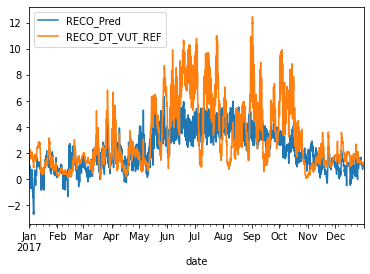

In [23]:
df_c = pd.concat([pred, df[['date','RECO_DT_VUT_REF']]], axis = 1)
df_c = df_c.rename(columns = {'TA_F':'RECO_Pred'})
df_c.plot(x = 'date')

In [24]:
rmse = m_rmse(df_c['RECO_DT_VUT_REF'], pred)#df_c['RECO_Pred'])
rmse

1.8845401647526614

##### 2.2.2 Reco with Linear Regression optimized parameters

In [25]:
m,c = lin_reg_grad_dec(a,b,t,df_c['RECO_DT_VUT_REF'], epochs = 1000)
pred_update = reco(m,c,t)

In [26]:
rmse_update = m_rmse(df_c['RECO_DT_VUT_REF'], pred_update)
rmse_update

1.7124295376071157

<AxesSubplot:xlabel='date'>

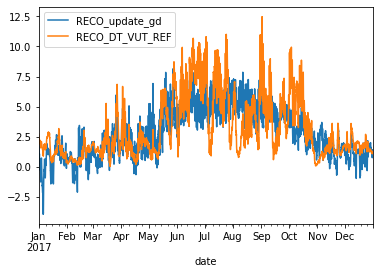

In [27]:
df_u = pd.concat([pred_update, df[['date','RECO_DT_VUT_REF']]], axis = 1)
df_u = df_u.rename(columns = {'TA_F':'RECO_update_gd'})
df_u.plot(x = 'date')

##### 2.2.3. Reco with diff evolution optimized parameters

In [28]:
# define the bounds on the search
temp = df['TA_F'].tolist()
resp = df['RECO_DT_VUT_REF'].tolist()
bounds = [[0, 0.5],[0.0, 1.2]]
# perform the differential evolution search
result = differential_evolution(func_reco, bounds, args = (temp,resp,))
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = func_reco(solution, temp, resp)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 294
Solution: f([0.26308923 1.2       ]) = 224.02917


In [29]:
# print(result['x'][0]) 
a_ev = result['x'][0]
b_ev = result['x'][1]
# print(a_ev.type)
# print(type(df['TA_F_MDS']))

In [30]:
pred_update_ev = reco(a_ev,b_ev,t)
rmse_update_ev = m_rmse(df_c['RECO_DT_VUT_REF'], pred_update_ev)
rmse_update_ev

1.6925344424715594

<AxesSubplot:xlabel='date'>

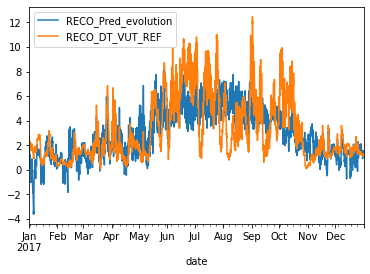

In [31]:
df_ue = pd.concat([pred_update_ev, df[['date','RECO_DT_VUT_REF']]], axis = 1)
df_ue = df_ue.rename(columns = {'TA_F':'RECO_Pred_evolution'})
df_ue.plot(x = 'date')

#### 2.3 Reco predictions with parameters (alpha, beta) optimized with morris, gradient decent and differential evolution for all stations 

In [32]:
# For all stations gradient decent, morris, diff_ev and vprm (wrf) params 
stations, snames = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)

In [ ]:
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
df_params_new = pd.DataFrame(index = snames, columns = ['morr_RMSE', 'new_RMSE_gd','new_RMSE_ev', 'alpha_gd', 'beta_gd', 'alpha_ev', 'beta_ev'])
for sitename in snames:
    df = get_station_observation_year(StationDataPath, sitename, year)
    
    # use morris params     
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']
    
    pred = reco(a,b,t)
    
    old_rmse = m_rmse(df['RECO_DT_VUT_REF'], pred)#df_c['RECO_Pred'])
    
    m,c = lin_reg_grad_dec(a,b,t,df['RECO_DT_VUT_REF'])
    pred_update = reco(m,c,t)
    
    rmse_update = m_rmse(df['RECO_DT_VUT_REF'], pred_update)
    
    # df_params_new.loc[sitename]['Station'] = sitename
    df_params_new.loc[sitename]['morr_RMSE'] = old_rmse
    df_params_new.loc[sitename]['new_RMSE_gd'] = rmse_update
    df_params_new.loc[sitename]['alpha_gd'] = m
    df_params_new.loc[sitename]['beta_gd'] = c 
    
    temp = df['TA_F'].tolist()
    resp = df['RECO_DT_VUT_REF'].tolist()
    bounds = [[0, 0.5],[0.0, 1.2]]
    result = differential_evolution(func_reco, bounds, args = (temp,resp,))

    # print('Status : %s' % result['message'])
    df_params_new.loc[sitename]['alpha_ev'] = result['x'][0]
    df_params_new.loc[sitename]['beta_ev'] = result['x'][1]
    
    pred_update_ev = reco(result['x'][0],result['x'][1],t)
    rmse_update_ev = m_rmse(df['RECO_DT_VUT_REF'], pred_update_ev)
    df_params_new.loc[sitename]['new_RMSE_ev'] = rmse_update_ev
    
    # print(df_params_new)

In [21]:
df_params_new

,morr_RMSE,new_RMSE_gd,new_RMSE_ev,alpha_gd,beta_gd,alpha_ev,beta_ev
FI-Hyy,1.759349,1.374486,1.16813,0.305539,0.546445,0.269051,1.2
FI-Let,3.040434,2.03224,1.992705,0.337118,0.892557,0.3183,1.2
SE-Lnn,1.579666,1.082679,1.073078,0.210606,0.228481,0.195313,0.440108
SE-Ros,1.475623,1.347292,1.037538,0.219419,0.375266,0.183522,1.2
SE-Deg,0.588318,0.396669,0.288572,0.052766,0.057344,0.04565,0.336105
SE-Htm,4.343196,1.943014,1.942877,0.476096,0.825572,0.478886,0.788867
SE-Nor,1.88454,1.71243,1.692534,0.272196,1.066395,0.263088,1.2


In [34]:
#VPRM parameters from WRF
# lambdaGPP 	radZero 	alpha 	beta 	Tmin 	Tmax 	Topt
parameters_wrf = {1:[275.4595, 0.22577703, 0.28773167, -1.09316696, 0., 40, 20.],
              2:[254.4188, 0.21489270, 0.18056630, 0.83641734, 0., 40, 20.,],
              3:[446.0888,0.16293380,0.24447911, -0.48669162, 0., 40, 20.],
              4:[70.3829,0.29311134,0.05464646, -0.12080592, 2., 40, 20.],
              5:[682.0, 0.1141, 0.0049, 0.0000, 2., 40, 20.],
              6:[1132.2, 0.08626603, 0.09231632,0.28788863, 5., 40, 22.],
              7:[527.9303, 0.11930965, 0.1245603, 0.01743361, 2., 40 ,18.],
              8:[0.00, 0.00, 0.00, 0, 0., 40, 0.]
             } 


In [23]:
df_params_new.to_csv('Oslo_analysis/VPRMoutput/best_fit_gd_alpha_beta'+str(year)+'.csv')


In [35]:
df_params_new = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_gd_alpha_beta'+str(year)+'.csv', index_col=0)
df_params_new

,morr_RMSE,new_RMSE_gd,new_RMSE_ev,alpha_gd,beta_gd,alpha_ev,beta_ev
FI-Hyy,1.759349,1.374486,1.168130,0.305539,0.546445,0.269051,1.200000
FI-Let,3.040434,2.032240,1.992705,0.337118,0.892557,0.318300,1.200000
SE-Lnn,1.579666,1.082679,1.073078,0.210606,0.228481,0.195313,0.440108
SE-Ros,1.475623,1.347292,1.037538,0.219419,0.375266,0.183522,1.200000
SE-Deg,0.588318,0.396669,0.288572,0.052766,0.057344,0.045650,0.336105
SE-Htm,4.343196,1.943014,1.942877,0.476096,0.825572,0.478886,0.788867
SE-Nor,1.884540,1.712430,1.692534,0.272196,1.066395,0.263088,1.200000


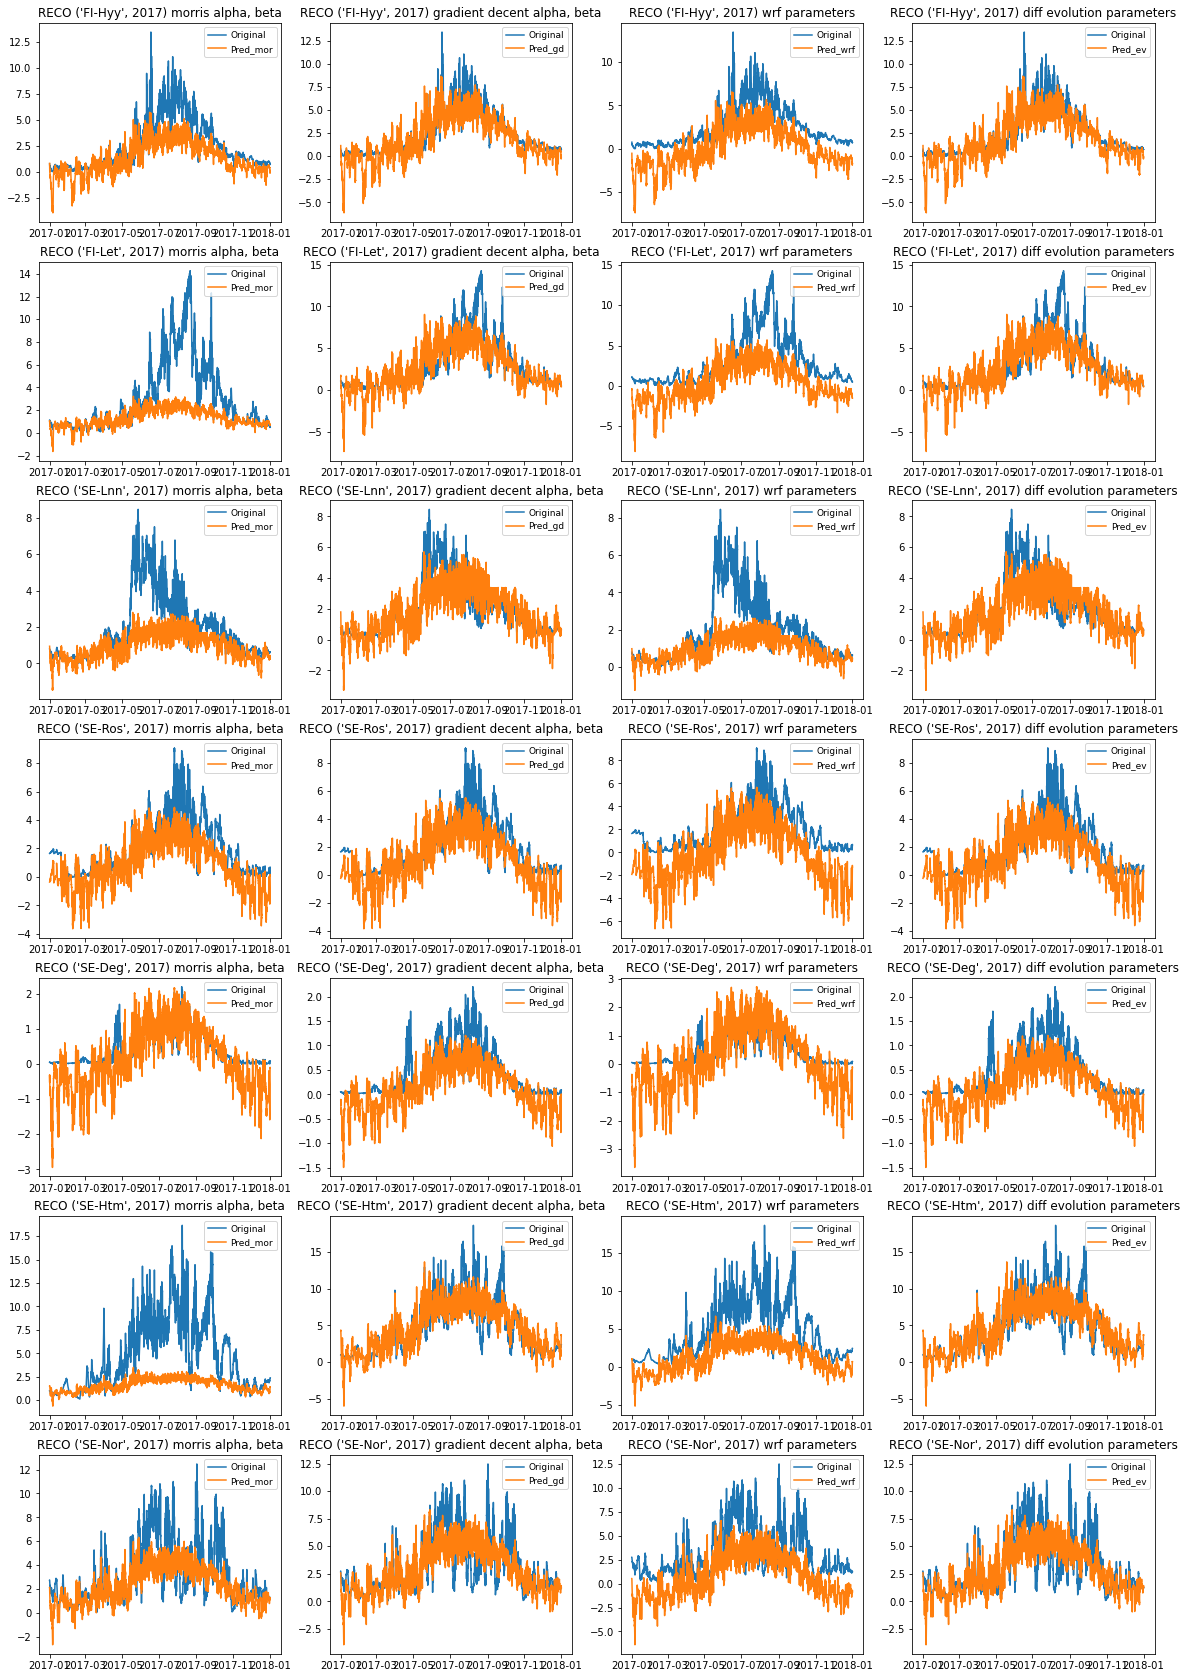

In [37]:
# plots of old and new prediction 
fig, ax = plt.subplots(len(snames), 4, figsize = (20,30))

for i, sitename in enumerate(snames):
    df = get_station_observation_year(StationDataPath, sitename, year)
    #The pred from morris parameters (df params)
    
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']
    
    pred = reco(a,b,t)
    
    df_c = pd.concat([pred, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_c = df_c.rename(columns = {'TA_F':'RECO_Pred'})
    
    #THe pred from gd parameters (df params new) 
    
    m = df_params_new.loc[sitename]['alpha_gd']
    c = df_params_new.loc[sitename]['beta_gd']
    
    pred_update = reco(m,c,t)
    
    df_u = pd.concat([pred_update, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_u = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    #The prediction from wrf parameters (dict parameters_wrf 
    
    iveg = params.at[sitename, 'iveg']
    para_wrf = parameters_wrf[iveg + 1]
    alpha_w = para_wrf[2]
    beta_w = para_wrf[3]
    
    pred_wrf = reco(alpha_w,beta_w,t)
    
    df_w = pd.concat([pred_wrf, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_w = df_w.rename(columns = {'TA_F':'RECO_Pred'})
    
    # print(df_w.head())
    # print(df_u.head())
    
    #The prediction with differential evolution
    ae = df_params_new.loc[sitename]['alpha_ev']
    be = df_params_new.loc[sitename]['beta_ev']
    
    pred_update_e = reco(m,c,t)
    
    df_e = pd.concat([pred_update_e, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_e = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    x = pd.to_datetime(df.date)
    # y = df.NEE_VUT_REF
    # yn = df.nans
    ax[i,0].plot(x,df_c['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,0].plot(x,df_c['RECO_Pred'], label = 'Pred_mor')

    ax[i,0].set_title(f'RECO {sitename, year} morris alpha, beta')
    ax[i,0].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)
    
    ax[i,1].plot(x,df_u['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,1].plot(x,df_u['RECO_Pred'], label = 'Pred_gd')

    ax[i,1].set_title(f'RECO {sitename, year} gradient decent alpha, beta')
    ax[i,1].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)   
    
    ax[i,2].plot(x,df_w['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,2].plot(x,df_w['RECO_Pred'], label = 'Pred_wrf')

    ax[i,2].set_title(f'RECO {sitename, year} wrf parameters')
    ax[i,2].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)
    
    ax[i,3].plot(x,df_e['RECO_DT_VUT_REF'], label = 'Original')
    ax[i,3].plot(x,df_e['RECO_Pred'], label = 'Pred_ev')

    ax[i,3].set_title(f'RECO {sitename, year} diff evolution parameters')
    ax[i,3].legend(loc='upper right', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)


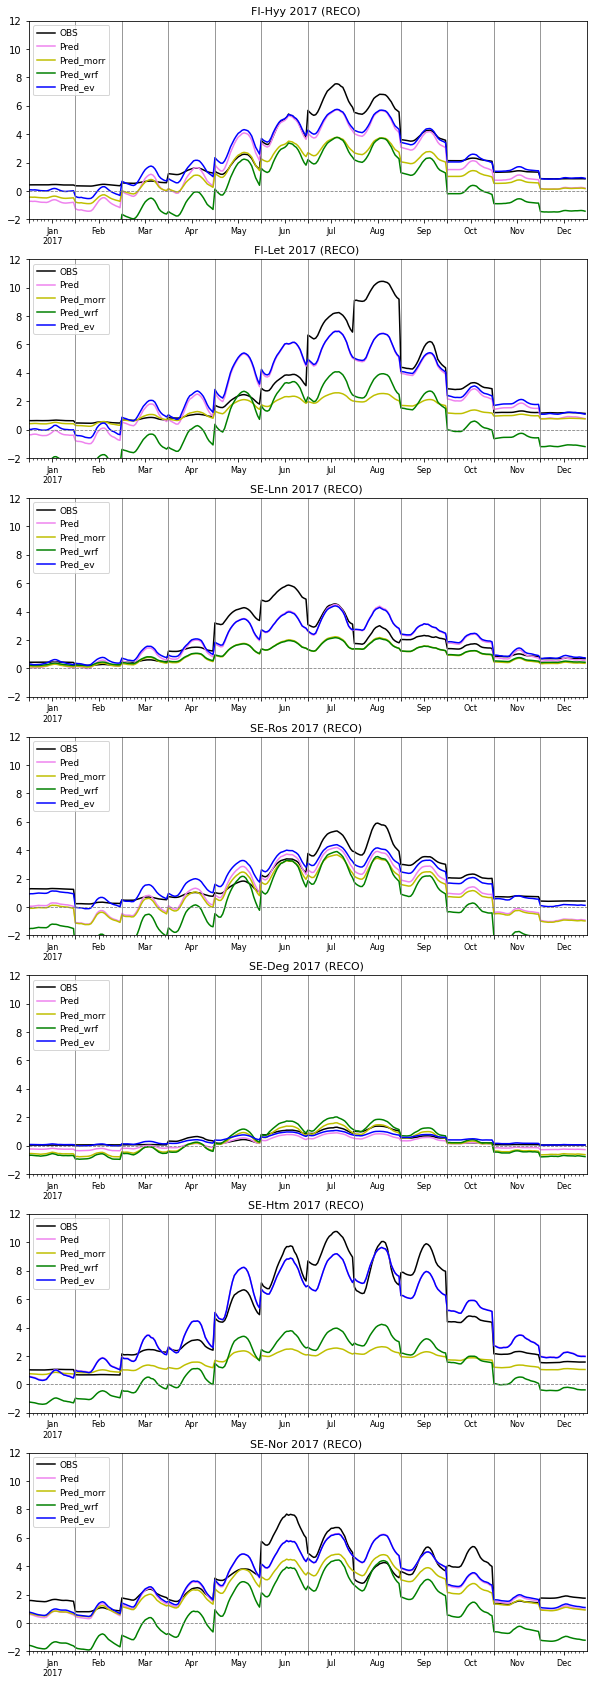

In [36]:
# plot diurnal of old and new prediction 
fig, ax = plt.subplots(len(snames), figsize = (10,30))

begin = pd.date_range(str(year) + "-01-01", periods=12, freq = "MS")
end = pd.date_range(str(year) +"-01-31", periods=12, freq="M")
label = 'Original' 
# unit = '($\mathrm{g_{CO_2} m^{-2} day^{-1}}$)'

for i, sitename in enumerate(snames):
# for sitename in snames: 
    '''
    1. Get the station observation 
    '''
    df = get_station_observation_year(StationDataPath, sitename, year)
    
    a = params.loc[sitename]['alpha']
    b = params.loc[sitename]['beta']
    t = df['TA_F']  
    pred = reco(a,b,t)   
    df_c = pd.concat([pred, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_c = df_c.rename(columns = {'TA_F':'RECO_Pred_morr'})
    
    m = df_params_new.loc[sitename]['alpha_gd']
    c = df_params_new.loc[sitename]['beta_gd']
    pred_update = reco(m,c,t)
    df_u = pd.DataFrame(pred_update)
    # df_u = pd.concat([pred_update, df[['RECO_DT_VUT_REF']]], axis = 1)
    df_u = df_u.rename(columns = {'TA_F':'RECO_Pred'})
    
    ae = df_params_new.loc[sitename]['alpha_ev']
    be = df_params_new.loc[sitename]['beta_ev']
    pred_update_e = reco(ae,be,t)
    df_e = pd.DataFrame(pred_update_e)
    # df_u = pd.concat([pred_update, df[['RECO_DT_VUT_REF']]], axis = 1)
    df_e = df_e.rename(columns = {'TA_F':'RECO_Pred_ev'})
    
    iveg = params.at[sitename, 'iveg']
    para_wrf = parameters_wrf[iveg + 1]
    alpha_w = para_wrf[2]
    beta_w = para_wrf[3]
    
    pred_wrf = reco(alpha_w,beta_w,t)
    df_w = pd.DataFrame(pred_wrf)
    # df_w = pd.concat([pred_wrf, df[['date','RECO_DT_VUT_REF']]], axis = 1)
    df_w = df_w.rename(columns = {'TA_F':'RECO_Pred_wrf'})
        
    df = pd.concat([df_c, df_u, df_w, df_e], axis = 1)#.reset_index(drop=True)
        
    '''
    4. Subplot Journal 
    '''
    morr_reco = []
    obs_reco = []
    opt_reco = []
    wrf_reco=[]
    ev_reco = []
    df.index = pd.to_datetime(df['date'])
    
    for month in range(len(begin)):
        df_opt_m = df[begin[month]:end[month]]
        df_opt_mean = df_opt_m.groupby([df_opt_m.index.hour]).mean()
        obs_reco.append(df_opt_mean['RECO_DT_VUT_REF'])

        morr_reco.append(df_opt_mean['RECO_Pred_morr'])
        
        opt_reco.append(df_opt_mean['RECO_Pred'])
        
        wrf_reco.append(df_opt_mean['RECO_Pred_wrf'])
        
        ev_reco.append(df_opt_mean['RECO_Pred_ev'])

            
    obs_reco = flatten_list_2d(obs_reco)
    opt_reco = flatten_list_2d(opt_reco)
    morr_reco = flatten_list_2d(morr_reco)
    wrf_reco = flatten_list_2d(wrf_reco)
    ev_reco = flatten_list_2d(ev_reco)

    time_day = np.arange(0,len(obs_reco))

    ax[i].plot(time_day, obs_reco, linewidth=1.5, color='k', label='OBS')
    ax[i].plot(time_day, opt_reco, linewidth=1.5, color = 'violet', label='Pred')
    ax[i].plot(time_day, morr_reco, linewidth=1.5, color = 'y', label='Pred_morr')
    ax[i].plot(time_day, wrf_reco, linewidth=1.5, color = 'g', label='Pred_wrf')
    ax[i].plot(time_day, ev_reco, linewidth=1.5, color = 'b', label='Pred_ev')


    legend=ax[i].legend(loc='upper left', shadow=False, fontsize=9, ncol=1, handletextpad=0.5)#, bbox_to_anchor=(1., 0.512))
    ax[i].set_xlim(0, 288)
    ax[i].set_ylim(-2, 12)
    for tt in range(24,288,24):
        ax[i].axvline(tt, color='grey', linewidth=0.8)
    ax[i].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    # ax[i].set_ylabel('Flux '+unit, fontsize=10)
    major_ticks = np.arange(0, 288, 12)
    minor_ticks = np.arange(0, 288, 2)
    ax[i].xaxis.set_ticks(major_ticks)
    ax[i].set_xticklabels(['','Jan\n'+str(year),'','Feb','','Mar','','Apr','','May','','Jun','','Jul','','Aug','','Sep','','Oct','','Nov','','Dec'])
    ax[i].xaxis.set_ticks(minor_ticks, minor = True)
    ax[i].xaxis.set_tick_params(which='major', labelsize=8)
    ax[i].set_title(sitename +' '+ str(year) + ' (RECO) ', fontsize=11)
# fig.savefig(cwd +'figures/'+ str(year)+'_stations_hh.png')   # save the figure to file

# fig1.savefig(cwd +'figures/'+str(year)+'_stations_diurnal.png')   # save the figure to file


### 3. Use different methods to update Parameters (GPP)


#### 3.1. OPtimize for one Station and year

In [38]:
# stations, snames = get_stations_year(year)
snames = ['FI-Hyy']
print(snames)

['FI-Hyy']


In [39]:
# load morris optimized params 
params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
params.columns = col_list
params.index = params.Station
params

,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
Station,,,,,,,,,
FI-Hyy,0.35,220.0,0.2,0.4,1.0,40.2,19.8,FI-Hyy,0
FI-Let,0.40,130.0,0.1,0.8,0.6,39.0,21.0,FI-Let,0
SE-Lnn,0.45,250.0,0.1,0.2,1.0,39.0,21.0,SE-Lnn,5
SE-Ros,0.35,220.0,0.2,0.2,1.0,39.0,19.4,SE-Ros,0
SE-Deg,0.20,100.0,0.1,0.0,0.6,40.2,21.0,SE-Deg,6
SE-Htm,0.45,250.0,0.1,0.8,-0.6,40.6,19.0,SE-Htm,0
SE-Nor,0.30,250.0,0.2,1.0,1.0,39.8,20.6,SE-Nor,0


In [40]:
station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)

In [41]:
df = station_data.filter(regex='FI-Hyy')

iveg = params.loc['FI-Hyy', 'iveg']
#params morris
TMIN = params.loc['FI-Hyy', 'Tmin']
TMAX = params.loc['FI-Hyy', 'Tmax']
TOPT = params.loc['FI-Hyy', 'Topt']
T_low = [4,0,2,3,0,0,0,-999,0]
tlow = T_low[iveg]
Temp = df['FI-Hyy_TEMP_Station']
EVI = df['FI-Hyy_EVI']
LSWI = df['FI-Hyy_LSWI']
Rad = df['FI-Hyy_RAD_Station']
EVImax = np.nanmax(EVI)
EVImin = np.nanmin(EVI)
LSWImax = np.nanmax(LSWI)
LSWImin = np.nanmin(LSWI)

In [42]:
Tscale = ((Temp - TMIN)*(Temp-TMAX))/(((Temp-TMIN)*(Temp-TMAX))-((Temp-TOPT)*(Temp-TOPT)))
Tscale[Tscale < 0] = 0
count = (Tscale == 0).sum()
count

7355

In [43]:
if iveg in [3, 6]:
    Wscale = (LSWI - LSWImin)/(LSWImax - LSWImin)
else:
    Wscale = (1 + LSWI)/(1 + LSWImax)

Wscale[Wscale < 0] = 0

In [44]:
Pscale = (1 + LSWI)/2
if iveg == 0:
    Pscale[:] = 1

if iveg in [1, 2, 3, 5, 7, 8]:
    threshmark = 0.55
    evithresh = EVImin + (threshmark*(EVImax-EVImin))
    phenologyselect = np.where(EVI[:] > evithresh)
    Pscale[phenologyselect] = 1
#by default, grasslands and savannas never have pScale=1
Pscale[Pscale < 0] = 0


In [45]:
lambdaGPP = params.loc['FI-Hyy', 'lambdaGPP']
radZero = params.loc['FI-Hyy', 'radZero']

In [46]:
#  predition wirth morris optimized parameters
gee = GEE_calculate(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero)
count = (gee == -0.0).sum()
count
print(gee.min())

-19.095834278823375


In [47]:
for sitename in snames:   
    print(snames)
    df_obs = get_station_observation_year(StationDataPath, sitename, year) 
    
    if 'GPP_DT_VUT_REF' in df_obs.columns:
        label = 'GPP_DT_VUT_REF'
    else:
        label = 'FC'

    df_obs.loc[df_obs[label] < -9990, label] = np.nan
    df_obs[label] = df_obs[label]#*3600
    df_obs.set_index('TIMESTAMP_START', inplace=True)
    df_obs = df_obs[[label]]

    GPP_obs = df_obs[label].values

['FI-Hyy']


In [48]:
frame = { 'Obs': GPP_obs*(-1), 'Pred': gee } 
result = pd.DataFrame(frame, index = gee.index)

<AxesSubplot:xlabel='Times'>

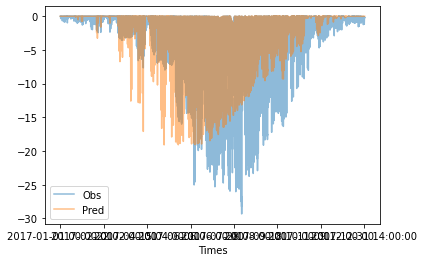

In [49]:
result.plot(alpha=0.5)

In [50]:
# root mean squared error between morris and original
rmse = m_rmse(result['Obs'], result['Pred'])
rmse

2.663790803930556

In [51]:
GEE_p = GPP_obs*(-1)

##### 3.1.1. Differential evolution GPP 

In [52]:
# 0.25 	220.0 (MORRIS) 
# 0.22577703 , 275.4595, (wrf) 
bounds = [[0.2, 0.3],[210, 280]]
# perform the differential evolution search
result = differential_evolution(func_gee, bounds, args = (Tscale, Wscale, Pscale, EVI, Rad, GEE_p,))
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])


Status : Optimization terminated successfully.
Total Evaluations: 306


In [53]:
# evaluate solution
solution = result['x']
evaluation = func_gee(solution, Tscale, Wscale, Pscale, EVI, Rad, GEE_p)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Solution: f([  0.3 280. ]) = 358.25020


In [54]:
print(type(solution[0]))
gee_ev = GEE_calculate(solution[0], Tscale, Wscale, Pscale, EVI, Rad, solution[1])

<class 'numpy.float64'>


<AxesSubplot:xlabel='Times'>

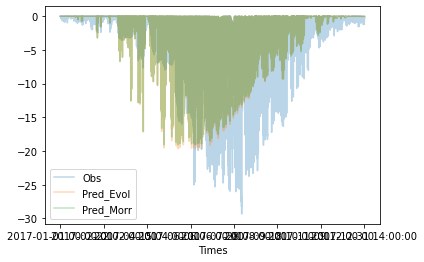

In [55]:
frame = { 'Obs': GEE_p, 'Pred_Evol': gee_ev, 'Pred_Morr' : gee} 
result_ev = pd.DataFrame(frame, index = gee_ev.index)
result_ev.plot(alpha = 0.3)

In [56]:
rmse = m_rmse(result_ev['Obs'], result_ev['Pred_Evol'])
rmse

2.7065708259680266

In [57]:
rmse = m_rmse(result_ev['Obs'], result_ev['Pred_Morr'])
rmse

2.663790803930556

##### 3.1.2. Gradient decent optimization

In [58]:
# Gradient Decent lambdaGPP 
print('morris: ', lambdaGPP, radZero) 
lambda_lr, rZ_lr = gpp_grad_dec(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GEE_p, L = 0.0001, epochs = 200)

morris:  0.35 220.0


In [59]:
print(lambda_lr, rZ_lr) 

0.3926743470603209 220.00001317513872


In [60]:
lambda_lr_n, rZ_lr_n = gpp_grad_dec(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GEE_p, L = 0.0001, epochs = 2000)


In [61]:
print(lambda_lr_n, rZ_lr_n)

0.3935368009705832 219.99971535157235


In [62]:
lambda_lr_m, rZ_lr_m = gpp_grad_dec(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GEE_p, L = 0.0001, epochs = 5000)


In [63]:
print(lambda_lr_m, rZ_lr_m)

0.39353737424577845 219.99921732744653


In [64]:
gee_gd = GEE_calculate(lambda_lr_m, Tscale, Wscale, Pscale, EVI, Rad, rZ_lr_m)

In [65]:
rmse = m_rmse(result_ev['Obs'], gee_gd)
rmse

2.593782943910045

<AxesSubplot:xlabel='Times'>

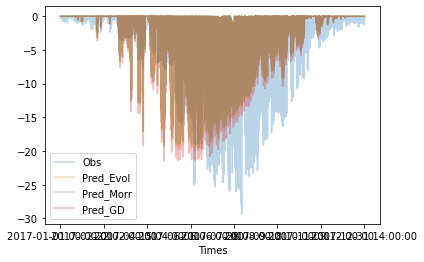

In [66]:
frame = { 'Obs': GEE_p, 'Pred_Evol': gee_ev, 'Pred_Morr' : gee, 'Pred_GD' : gee_gd} 
result_ev = pd.DataFrame(frame, index = gee_ev.index)
result_ev.plot(alpha = 0.3)

#### 3.2 Optimize GPP params (lambda, radZero) for all stations one year 

In [67]:
# For all stations gradient decent, morris, diff_ev and vprm (wrf) params 
stations, snames = get_stations_year(year)
stations.set_index(stations['Station'], inplace=True)

In [68]:
params = pd.read_csv('Oslo_analysis/VPRMoutput/best_fit_morris_'+str(year)+'.csv', header = None)
col_list = ['lambdaGPP', 'radZero', 'alpha', 'beta', 'Tmin', 'Tmax', 'Topt', 'Station', 'iveg']
params.columns = col_list
params.index = params.Station
params

,lambdaGPP,radZero,alpha,beta,Tmin,Tmax,Topt,Station,iveg
Station,,,,,,,,,
FI-Hyy,0.35,220.0,0.2,0.4,1.0,40.2,19.8,FI-Hyy,0
FI-Let,0.40,130.0,0.1,0.8,0.6,39.0,21.0,FI-Let,0
SE-Lnn,0.45,250.0,0.1,0.2,1.0,39.0,21.0,SE-Lnn,5
SE-Ros,0.35,220.0,0.2,0.2,1.0,39.0,19.4,SE-Ros,0
SE-Deg,0.20,100.0,0.1,0.0,0.6,40.2,21.0,SE-Deg,6
SE-Htm,0.45,250.0,0.1,0.8,-0.6,40.6,19.0,SE-Htm,0
SE-Nor,0.30,250.0,0.2,1.0,1.0,39.8,20.6,SE-Nor,0


In [238]:
# df (csv with year) with stationname, updated alpha beta rmse old rmse new for all stations 
df_params_gpp = pd.DataFrame(index = snames, columns = ['morr_RMSE', 'new_RMSE_gd','new_RMSE_ev', 'lambdaGPP_gd', 'radZero_gd', 'lambdaGPP_ev', 'radZero_ev'])
station_data = pd.read_csv('Oslo_analysis/Station_evi_lswi_temp_rad_'+str(year)+'.csv', header = 0, index_col=0)
for sitename in snames:
    print(sitename) 
    #get morris optimized parameters, meterological data and sentinel data 
    lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or = load_data_gpp(params, station_data, sitename, year, StationDataPath)
    
    print('lamda: ', lambdaGPP, 'tscale: ', Tscale.shape, 'wscale: ', Wscale.shape, 'pscale: ', Pscale.shape, 'evi: ', EVI.shape, 'rad: ', Rad.shape, 'radZ: ', radZero,'original: ', GPP_or.shape)
    
    
    #  predition wirth morris optimized parameters
    gee = GEE_calculate(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero)
    old_rmse = m_rmse(GPP_or, gee)
    
    # optimize params with gd     
    lambda_lr, rZ_lr = gpp_grad_dec(lambdaGPP, Tscale, Wscale, Pscale, EVI, Rad, radZero, GPP_or, L = 0.0001, epochs = 2000)
    
    gee_gd = GEE_calculate(lambda_lr, Tscale, Wscale, Pscale, EVI, Rad, rZ_lr)
    rmse_gd = m_rmse(GPP_or, gee_gd)
    
    # optimize params with diff evolution
    a = [lambdaGPP-0.1, lambdaGPP+0.1]
    b = [radZero-50, radZero+50]
    bounds = [a,b]
    result = differential_evolution(func_gee, bounds, args = (Tscale, Wscale, Pscale, EVI, Rad, GPP_or,))
    solution = result['x']
    
    gee_ev = GEE_calculate(solution[0], Tscale, Wscale, Pscale, EVI, Rad, solution[1])
    rmse_ev = m_rmse(GPP_or, gee_ev) 
    
    # df_params_gpp.loc[sitename]['Station'] = sitename
    df_params_gpp.loc[sitename]['morr_RMSE'] = old_rmse
    
    df_params_gpp.loc[sitename]['new_RMSE_gd'] = rmse_gd
    df_params_gpp.loc[sitename]['lambdaGPP_gd'] = lambda_lr
    df_params_gpp.loc[sitename]['radZero_gd'] = rZ_lr 
    
    df_params_gpp.loc[sitename]['new_RMSE_ev'] = rmse_ev
    df_params_gpp.loc[sitename]['lambdaGPP_ev'] = solution[0]
    df_params_gpp.loc[sitename]['radZero_ev'] = solution[1]
    

FI-Hyy
lamda:  0.35 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  220.0 original:  (17520,)
FI-Let
lamda:  0.4 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  130.0 original:  (17520,)
SE-Lnn
lamda:  0.45 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)
SE-Ros
lamda:  0.35 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  220.0 original:  (17520,)
SE-Deg
lamda:  0.2 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  100.0 original:  (17520,)
SE-Htm
lamda:  0.45 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)
SE-Nor
lamda:  0.3 tscale:  (17520,) wscale:  (17520,) pscale:  (17520,) evi:  (17520,) rad:  (17520,) radZ:  250.0 original:  (17520,)


In [ ]:
df_params_gpp.to_csv('Oslo_analysis/VPRMoutput/best_fit_gd_lambda_radZero'+str(year)+'.csv')

In [240]:
df_params_gpp

,morr_RMSE,new_RMSE_gd,new_RMSE_ev,lambdaGPP_gd,radZero_gd,lambdaGPP_ev,radZero_ev
FI-Hyy,2.663791,2.593783,2.569387,0.393537,219.999715,0.45,176.560233
FI-Let,3.732264,3.611416,3.612649,0.511582,129.999944,0.5,131.039455
SE-Lnn,6.729713,6.627211,6.619276,0.660539,250.000687,0.55,300.0
SE-Ros,1.883819,1.859512,1.836396,0.37466,219.999833,0.444958,170.0
SE-Deg,0.997635,0.831306,0.805771,0.37321,100.000377,0.3,150.0
SE-Htm,5.444274,3.745518,4.36803,0.822793,250.000926,0.55,300.0
SE-Nor,2.229968,2.219399,2.218008,0.313637,250.00005,0.290101,284.678786


In [69]:
#plots yearly HH and diurnal for ech station GPP? 